# Experiment 9: Random Forest + Reject Option Classification (Post-Processing) - Retrain + Validate

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Step 0: Setup Environment
!pip install aif360 shap scikit-learn pandas matplotlib seaborn joblib openpyxl --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 5.9 MB/s eta 0:00:00


In [3]:
# Step 1: Imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import shap
import matplotlib.pyplot as plt

from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.postprocessing import RejectOptionClassification


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [4]:

# Step 2: Load and Preprocess Training Dataset
df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')

selected_cols = ['loan_status', 'annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'zip_code']
df = df[selected_cols].dropna().copy()

df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

for col in ['term', 'grade', 'home_ownership', 'purpose', 'zip_code']:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

df['annual_inc'] = StandardScaler().fit_transform(df[['annual_inc']])

privileged_groups = [{'zip_code': 1}]
unprivileged_groups = [{'zip_code': 0}]

aif_data = StandardDataset(df,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])

X = aif_data.features
y = aif_data.labels.ravel()


In [5]:


# Step 3: Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

RandomForestClassifier(random_state=42)

In [6]:


# Step 4: Preprocess External Test Dataset
def preprocess_testdata(df):
    df = df.copy()
    processed = pd.DataFrame()

    scaler = StandardScaler()
    processed['annual_inc'] = scaler.fit_transform(df[['annual_inc']].fillna(df['annual_inc'].median())).ravel()

    le = LabelEncoder()
    processed['term'] = le.fit_transform(df['term'].astype(str))

    le = LabelEncoder()
    processed['grade'] = le.fit_transform(df['grade'].astype(str))

    le = LabelEncoder()
    processed['home_ownership'] = le.fit_transform(df['home_ownership'].astype(str))

    le = LabelEncoder()
    processed['purpose'] = le.fit_transform(df['purpose'].astype(str))

    le = LabelEncoder()
    processed['zip_code'] = le.fit_transform(df['zip_code'].astype(str))

    status_map = {
        'Fully Paid': 1,
        'Current': 1,
        'Charged Off': 0,
        'Default': 0,
        'Late (31-120 days)': 0,
        'Late (16-30 days)': 0,
        'In Grace Period': 0
    }
    df['loan_status_mapped'] = df['loan_status'].map(status_map).fillna(0).astype(int)
    processed['loan_status'] = df['loan_status_mapped']

    return processed.dropna()





In [7]:
# Step 5: Run Validation with ROC
RESULTS_DIR = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results'
TESTDATA_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation dataset/TestData set.xlsx'

test_df = pd.read_excel(TESTDATA_PATH)
test_processed = preprocess_testdata(test_df)

aif_test = StandardDataset(test_processed,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])

X_test = aif_test.features
y_test = aif_test.labels.ravel()

# Predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

pred_dataset = aif_test.copy()
pred_dataset.labels = y_pred.reshape(-1, 1)
pred_dataset.scores = y_prob.reshape(-1, 1)

# Apply Reject Option Classification
roc = RejectOptionClassification(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    low_class_thresh=0.01,
    high_class_thresh=0.99,
    num_class_thresh=100,
    num_ROC_margin=50,
    metric_name="Statistical parity difference",
    metric_ub=0.05,
    metric_lb=-0.05
)
roc = roc.fit(aif_test, pred_dataset)
post_dataset = roc.predict(pred_dataset)



In [8]:

# Step 6: Evaluate Performance and Fairness
print('\nPERFORMANCE METRICS (After ROC)')
print("Accuracy:", accuracy_score(y_test, post_dataset.labels.ravel()))
print("Precision:", precision_score(y_test, post_dataset.labels.ravel()))
print("Recall:", recall_score(y_test, post_dataset.labels.ravel()))
print("F1 Score:", f1_score(y_test, post_dataset.labels.ravel()))
print("AUC-ROC:", roc_auc_score(y_test, post_dataset.scores.ravel()))

print('\nClassification Report:')
print(classification_report(y_test, post_dataset.labels.ravel(), zero_division=0))

metric_post = ClassificationMetric(aif_test, post_dataset,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

print('\nFAIRNESS METRICS (After ROC)')
print("Statistical Parity Difference:", metric_post.statistical_parity_difference())
print("Disparate Impact:", metric_post.disparate_impact())
print("Equal Opportunity Difference:", metric_post.equal_opportunity_difference())
print("Average Odds Difference:", metric_post.average_odds_difference())
print("Bias Amplification:", metric_post.between_group_generalized_entropy_index())
print("Theil Index:", metric_post.theil_index())



PERFORMANCE METRICS (After ROC)
Accuracy: 0.5416916616676665
Precision: 0.8740490278951818
Recall: 0.5091088133924175
F1 Score: 0.6434349719975109
AUC-ROC: 0.6158284607749216

Classification Report:
              precision    recall  f1-score   support

         0.0       0.24      0.68      0.36       939
         1.0       0.87      0.51      0.64      4062

    accuracy                           0.54      5001
   macro avg       0.56      0.60      0.50      5001
weighted avg       0.76      0.54      0.59      5001


FAIRNESS METRICS (After ROC)
Statistical Parity Difference: 0.0
Disparate Impact: nan
Equal Opportunity Difference: nan
Average Odds Difference: nan
Bias Amplification: 1249.75
Theil Index: 0.5391986111493733


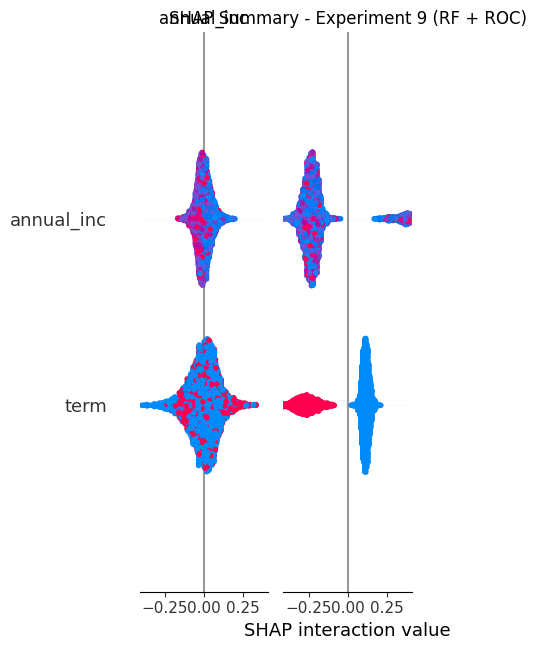

In [9]:
# Step 7: SHAP Explainability
X_df = pd.DataFrame(X_test, columns=aif_test.feature_names)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_df)

if isinstance(shap_values, list):
    shap_arr = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_arr = shap_values

shap.summary_plot(shap_arr, X_df, plot_type="bar", show=False)
plt.title('SHAP Summary - Experiment 9 (RF + ROC)')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/shap_exp9_testdata.png', dpi=150)
plt.show()

In [10]:
# Step 8: Save Results
results = {
    'Accuracy': accuracy_score(y_test, post_dataset.labels.ravel()),
    'Precision': precision_score(y_test, post_dataset.labels.ravel()),
    'Recall': recall_score(y_test, post_dataset.labels.ravel()),
    'F1': f1_score(y_test, post_dataset.labels.ravel()),
    'AUC': roc_auc_score(y_test, post_dataset.scores.ravel()),
    'SPD': metric_post.statistical_parity_difference(),
    'DI': metric_post.disparate_impact(),
    'EOD': metric_post.equal_opportunity_difference(),
    'AOD': metric_post.average_odds_difference(),
    'BiasAmp': metric_post.between_group_generalized_entropy_index(),
    'Theil': metric_post.theil_index()
}

output_path = f'{RESULTS_DIR}/experiment9_validation_results_testdata.csv'
pd.DataFrame([results]).to_csv(output_path, index=False)
print(f'\nResults saved to: {output_path}')


Results saved to: /content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results/experiment9_validation_results_testdata.csv
